In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [3]:
from regression_classifier import *

In [4]:
df = pd.read_csv('./data/AB_NYC_2019_EDA.csv').drop(['Unnamed: 0'], axis=1)

target_name = 'price'

In [5]:
X, y = df.drop(columns=[target_name]), df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Test ClassRegressor

In [6]:
df.head()

,neighbourhood,price,availability_365,n-hood_group_Brooklyn,n-hood_group_Manhattan,n-hood_group_Queens,n-hood_group_Staten Island,room_type_Private room,room_type_Shared room,Manh_dist,Broo_dist,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,log_calculated_host_listings_count
0,92.669640,149,365,1,0,0,0,1,0,0.133675,0.025206,0.693147,2.302585,-1.560648,1.791759
1,252.614598,225,355,0,1,0,0,0,0,0.032827,0.108917,0.693147,3.828641,-0.967584,0.693147
2,109.915169,150,365,0,1,0,0,1,0,0.036737,0.158162,1.386294,0.000000,-0.328504,0.000000
3,140.791735,89,194,1,0,0,0,0,0,0.096037,0.036351,0.693147,5.602119,1.534714,0.000000
4,121.010757,80,0,0,1,0,0,0,0,0.027858,0.147596,2.397895,2.302585,-2.302585,0.000000


<AxesSubplot:>

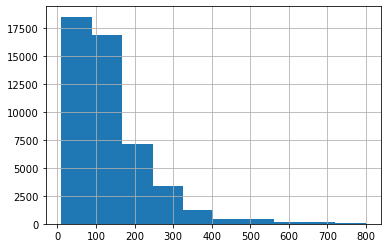

In [7]:
y.hist()

In [8]:
df[target_name].describe()

count    48410.000000
mean       137.575170
std        103.780081
min         10.000000
25%         69.000000
50%        105.000000
75%        175.000000
max        799.000000
Name: price, dtype: float64

In [9]:
clf_perc = ClassRegressor(n_bins=2, bins_calc_method='percentile')
clf_perc.fit(X, y)

clf_perc.bin_borders

array([[ 10., 105.],
       [105., 799.]])

In [10]:
pd.Series(clf_perc.y_classes).value_counts()

0    24426
1    23984
dtype: int64

In [11]:
pd.Series(clf_perc.predict(X, regression=True)).value_counts()

207.779686    25010
68.641038     23400
dtype: int64

In [12]:
clf_perc = ClassRegressor(n_bins=2, bins_calc_method='percentile')
clf_perc.fit(X_train_scaled, y_train)

pred_train = clf_perc.predict(X_train_scaled, regression=True)
pred_test = clf_perc.predict(X_test_scaled, regression=True)

print('Class regressor ()')
print('train mae', mean_absolute_error(y_train, pred_train))
print('test mae', mean_absolute_error(y_test, pred_test))

Class regressor ()
train mae 56.789803595553714
test mae 57.16349639193194


<AxesSubplot:>

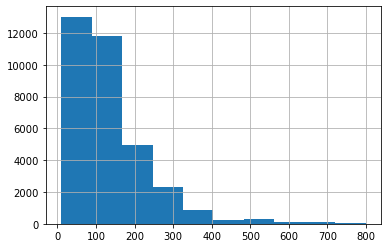

In [13]:
y_train.hist()

<AxesSubplot:>

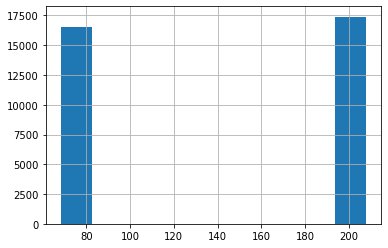

In [14]:
pd.Series(pred_train).hist()

In [15]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_scaled, y_train)


pred_train = dummy_regr.predict(X_train_scaled)
pred_test = dummy_regr.predict(X_test_scaled)

print('Dummy regressor')
print('train mae', mean_absolute_error(y_train, pred_train))
print('test mae', mean_absolute_error(y_test, pred_test))

Dummy regressor
train mae 73.40003703765083
test mae 73.39060713427676


# Test ClassRegressorEnsemble (with LinearRegression)

In [16]:
N_BINS = 2
N_LEVELS = 1

class_reg = ClassRegressorEnsemble(n_bins=N_BINS, n_levels=N_LEVELS, bins_calc_method='percentile', leaf_model=LinearRegression)

class_reg.fit(X_train_scaled, y_train)

In [17]:
class_reg.models

{(0,
  (0,)): <regression_classifier.class_regressor.ClassRegressor at 0x11dd78fdd60>}

In [18]:
class_reg.models[(0, (0,))].bin_borders

array([[ 10., 105.],
       [105., 799.]])

In [19]:
#class_reg.models[(1, (0, 0))].bin_borders

In [20]:
#class_reg.models[(1, (0, 1))].bin_borders

In [21]:
X_train_scaled.iloc[0], y_train.iloc[0]

(neighbourhood                         2.390667
 availability_365                      0.804064
 n-hood_group_Brooklyn                -0.834955
 n-hood_group_Manhattan                1.123723
 n-hood_group_Queens                  -0.364281
 n-hood_group_Staten Island           -0.088610
 room_type_Private room               -0.925042
 room_type_Shared room                -0.156487
 Manh_dist                            -1.076243
 Broo_dist                             0.198089
 log_minimum_nights                    0.128277
 log_number_of_reviews                -0.838499
 log_reviews_per_month                -0.036852
 log_calculated_host_listings_count    1.449238
 Name: 0, dtype: float64,
 419)

In [22]:
class_reg.models[(0, (0,))].predict(X_train_scaled.iloc[:1])

array([1], dtype=int64)

In [23]:
class_reg.predict(X_train_scaled.iloc[:1])

array([301.1729848])

<AxesSubplot:>

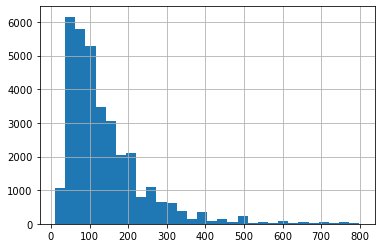

In [24]:
y_train.hist(bins=30)

<AxesSubplot:>

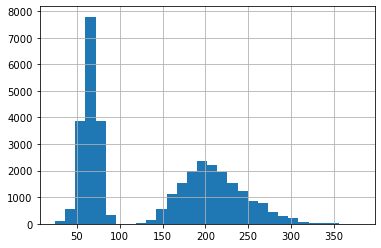

In [25]:
pred_train = class_reg.predict(X_train_scaled)
pd.Series(pred_train).hist(bins=30)

In [26]:
class_reg = ClassRegressorEnsemble(n_bins=N_BINS, n_levels=N_LEVELS, 
                                               bins_calc_method='percentile', 
                                               leaf_model=LinearRegression)
class_reg.fit(X_train_scaled, y_train)

pred_train = class_reg.predict(X_train_scaled)
pred_test = class_reg.predict(X_test_scaled)

print('Simple ClassRegressor ensemble')
print('train mae', mean_absolute_error(y_train, pred_train))
print('test mae', mean_absolute_error(y_test, pred_test))

Simple ClassRegressor ensemble
train mae 51.88738725607617
test mae 52.06536505175922


In [27]:
class_reg = ClassRegressorEnsemble(n_bins=100, n_levels=1, 
                                               bins_calc_method='percentile', 
                                               leaf_model=None)
class_reg.fit(X_train_scaled, y_train)

pred_train = class_reg.predict(X_train_scaled)
pred_test = class_reg.predict(X_test_scaled)

print('Simple ClassRegressor ensemble')
print('train mae', mean_absolute_error(y_train, pred_train))
print('test mae', mean_absolute_error(y_test, pred_test))

Simple ClassRegressor ensemble
train mae 50.643933124513545
test mae 50.64557726534679


# Difficult case for qcut

In [28]:
a = 3.891820
b = 3.871201
c = 3.850148
d = 3.912023
numb_a = 258
numb_b = 145
numb_c = 109
numb_d = 1082

list_test = numb_a * [a] + numb_b * [b] + numb_c * [c] +  + numb_d * [d]
y = pd.Series(list_test).sample(frac=1).reset_index(drop=True)
y.value_counts()

3.912023    1082
3.891820     258
3.871201     145
3.850148     109
dtype: int64

In [29]:
n_bins=2
bin_borders = pd.qcut(y, q=n_bins, labels=None, retbins=True, duplicates='drop')
bin_borders[1]

array([3.850148, 3.912023])

# Same result with stats.mstats.mquantiles

In [30]:
from scipy import stats

prob_list = np.linspace(0, 1, n_bins+1, endpoint=True)
prob_list

array([0. , 0.5, 1. ])

In [31]:
bin_borders = stats.mstats.mquantiles(y, prob_list)
np.unique(bin_borders)

array([3.850148, 3.912023])